# Week 7 Assignment

This week we are collecting some data from Reddit and doing some basic EDA on it. You should:

- create your Reddit account and API keys
- collect data from a subreddit of your choice
    - at a minimum, collect the posts from the subreddit; optionally collect comments on the posts
- save the data to a SQLite3 database
- perform some basic EDA on the data
    - create at least 2 plots
- write a short analysis at the end describing the process and results
- turn in the Jupyter Notebook and PDF printout or export to the week 7 dropbox

***Optional* advanced section**
- Practice SQL queries and select a subsection of the posts you collected
- Modify your code to collect data beyond the 1000 item limit
- Collect comments from the posts for analysis next week and do some EDA on the comments (e.g. who is the top commenter, which commenters have the most up and down votes or most controversial posts, etc)
- examine n-grams ([bigrams](https://stackoverflow.com/a/37651184/4549682), trigrams) or [collocations](https://www.geeksforgeeks.org/nlp-word-collocations/)

Note: There is no solution file for this week.

In [1]:
pip install praw

   ---------------------------------------- 0.0/191.0 kB ? eta -:--:--
   -- ------------------------------------- 10.2/191.0 kB ? eta -:--:--
   ------ -------------------------------- 30.7/191.0 kB 435.7 kB/s eta 0:00:01
   ---------------- ---------------------- 81.9/191.0 kB 762.6 kB/s eta 0:00:01
   -------------------------------- ------- 153.6/191.0 kB 1.0 MB/s eta 0:00:01
   ---------------------------------------- 191.0/191.0 kB 1.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
# Import the PRAW library
import praw

In [2]:
class Credentials:
    def __init__(self):
        self.client_id = 'yGIU5QOBNGdQioQwMgS_FQ'
        self.client_secret = 'P6btOgcyt3e_KHURyQTSZuBH4ZKEIw'
        self.user_agent = 'Current_Sherbet_4500'

The Credential class will store authentication information for the Reddit API. Information to be stored will include Client ID, client secret, and user agent. That way, it is easy to manage and then utilize these credentials anywhere in the application.

In [4]:
# Intializing the credentials
credentials = Credentials()

In [7]:
# Initialize Reddit instance
reddit = praw.Reddit(
    client_id=credentials.client_id,
    client_secret=credentials.client_secret,
    user_agent=credentials.user_agent
)

This code initializes a Reddit instance using the praw library by passing the necessary authentication credentials: client_id, client_secret, and user_agent. This instance enables interaction with the Reddit API to access data and perform actions on the platform.

In [9]:
# Example usage: print the titles of the top posts in a subreddit
subreddit = reddit.subreddit('Cricket')
for submission in subreddit.top(limit=5):
    print(submission.title)

BREAKING: Australia cricket legend, Shane Warne, dies aged 52 of ‘suspected heart attack’
Rohit Sharma announces his T20I retirement 
Stokes 135 Not out. Legend. One of the greatest knocks of all time.
India are the champions of T20 World Cup 2024
Australia are champions of the 2023 ODI World Cup


The above code fetches and prints the titles of the top five posts from the "Cricket" subreddit, displaying newsworthy news items and achievements regarding the sport. These headlines often regard legendary players, major matches, or championship victories and tend to reflect current events in cricket.

In [10]:
# Collect posts and comments
posts_data = []

In [11]:
# Fetch the top posts
for submission in subreddit.top(limit=10): 
    post = {
        'title': submission.title,
        'url': submission.url,
        'score': submission.score,
        'comments': []
    }

In [21]:
submission.comments.replace_more(limit=0)
for comment in submission.comments.list():
        post['comments'].append(comment.body)

posts_data.append(post)


In [22]:
# Display collected data
for post in posts_data:
    print(f"Title: {post['title']}\nScore: {post['score']}\nURL: {post['url']}")
    print("Comments:")
    for comment in post['comments']:
        print(f"- {comment}")
    print("\n")

Title: NEW ZEALAND ARE THE INAUGURAL ICC WORLD TEST CHAMPIONSHIP WINNERS
Score: 8252
URL: https://i.redd.it/09wldq07x1771.jpg
Comments:
- So apt that two of NZ's greatest ever batsmen take them to the title, with the longest-serving one hitting the winning runs. Poetic.
- GG NZ well deserved
- I’m just so happy. And so happy for the team too. It’s hard to imagine for most countries what this means to people like me. I’ve been a cricket fan my entire life and we’ve literally not won any ICC tournaments since I was 6. I am so proud of the effort we’ve shown for such a tiny little nation and how far we’ve come from the dark days of the 2000s.
- How fitting that it was two of New Zealand's all-time most prolific batsmen. Congrats Kiwi's. You guys showed how test cricket is meant to be played. Well deserved
- The fact that it was Rosco and Kanos. Happiest I’ve ever been after a sports event
- Deserved for NZ, so happy for you. 

I feel that India might have individual players who are better

# Save data to sqlite

In [24]:
import sqlite3

conn = sqlite3.connect('reddit_data.db')
cursor = conn.cursor()

In [30]:

# Connect to SQLite database (or create it)
conn = sqlite3.connect('reddit_data.db')
cursor = conn.cursor()

# Create tables function
def create_tables(cursor):
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS posts (
        id INTEGER PRIMARY KEY,
        title TEXT,
        url TEXT,
        score INTEGER
    )
    ''')
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS comments (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        post_id INTEGER,
        body TEXT,
        FOREIGN KEY (post_id) REFERENCES posts (id)
    )
    ''')

# Create tables
create_tables(cursor)

# Collect posts and comments
posts_data = []
for submission in subreddit.top(limit=10):  # Change limit as needed
    post = {
        'title': submission.title,
        'url': submission.url,
        'score': submission.score
    }

    # Insert post into the database
    cursor.execute('''
    INSERT INTO posts (title, url, score)
    VALUES (?, ?, ?)
    ''', (post['title'], post['url'], post['score']))
    
    post_id = cursor.lastrowid  # Get the id of the inserted post

    # Optionally collect comments
    submission.comments.replace_more(limit=0)  # Limit the number of comments to fetch
    for comment in submission.comments.list():
        # Insert comment into the database
        cursor.execute('''
        INSERT INTO comments (post_id, body)
        VALUES (?, ?)
        ''', (post_id, comment.body))

# Commit the changes
conn.commit()

# Close the connection
conn.close()

print("Data saved to SQLite database.")

Data saved to SQLite database.


This script creates an SQLite database if it doesn't currently exist and defines a function that creates two tables: one for posts and one for comments. It then retrieves the top 10 posts from the specified subreddit, inserts the post titles, URLs, and scores into the Posts table, while it concurrently fetches comments associated with every single post and saves them to the Comments table. It commits the changes to the database and closes the connection, finally confirming that data has been saved.

# EDA on the data

In [31]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to the SQLite database
conn = sqlite3.connect('reddit_data.db')

# Load posts data into a DataFrame
posts_df = pd.read_sql_query("SELECT * FROM posts", conn)

# Load comments data into a DataFrame
comments_df = pd.read_sql_query("SELECT * FROM comments", conn)

# Close the database connection
conn.close()

# Display basic information about the posts data
print(posts_df.info())
print(posts_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      30 non-null     int64 
 1   title   30 non-null     object
 2   url     30 non-null     object
 3   score   30 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 1.1+ KB
None
              id         score
count  30.000000     30.000000
mean   15.500000   8533.066667
std     8.803408   3735.526311
min     1.000000   5171.000000
25%     8.250000   5701.500000
50%    15.500000   7858.500000
75%    22.750000   9327.500000
max    30.000000  22942.000000


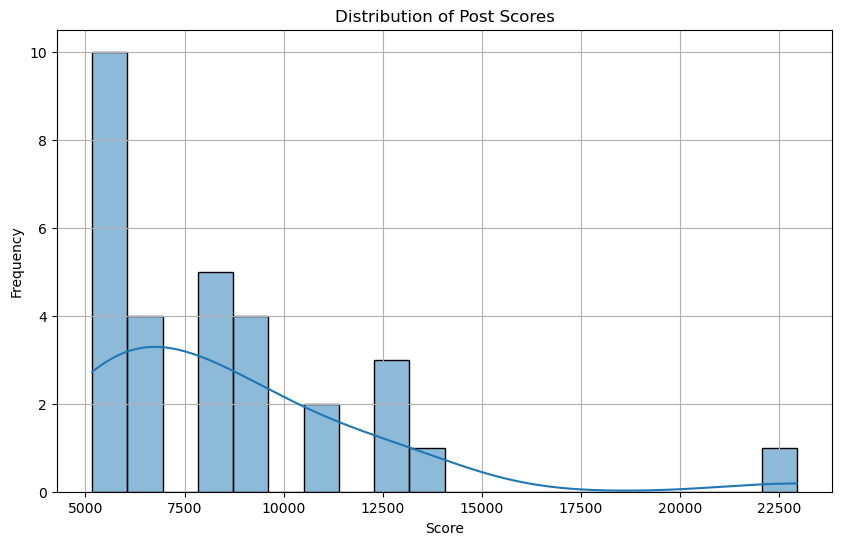

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot(posts_df['score'], bins=20, kde=True)
plt.title('Distribution of Post Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid()
plt.show()

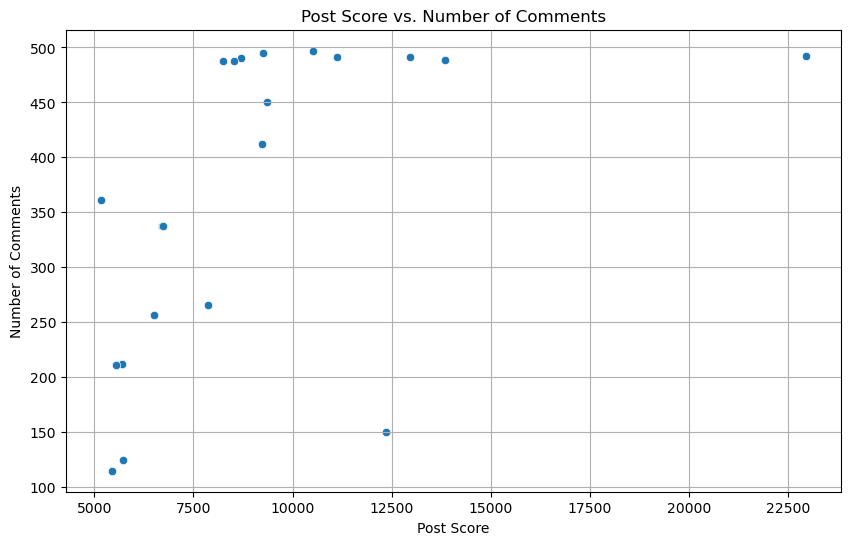

In [34]:
# 2. Plot 2: Relationship between Number of Comments and Post Score
# First, we need to count the number of comments per post
comment_counts = comments_df['post_id'].value_counts().reset_index()
comment_counts.columns = ['post_id', 'comment_count']

# Merge the comment counts with the posts DataFrame
merged_df = posts_df.merge(comment_counts, left_on='id', right_on='post_id', how='left')
merged_df['comment_count'] = merged_df['comment_count'].fillna(0) 

plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='score', y='comment_count')
plt.title('Post Score vs. Number of Comments')
plt.xlabel('Post Score')
plt.ylabel('Number of Comments')
plt.grid()
plt.show()

# Analysis

Begin by installing the necessary library, PRAW, along with the pandas library to handle data, and matplotlib and seaborn for data visualization. Next, you'll define a Credentials class to hold your Reddit API credentials and create an instance of the Reddit class to fetch posts from subreddits. You will then connect to an SQLite database and create two tables for posts and comments. Then, for an subreddit name specified by you, fetch its posts and scrape their titles, URLs, scores, and comments. Save data to the database. Then, immediately load the data from the database into pandas DataFrames to perform basic exploratory data analysis-EDA: computing summary statistics, and later visualize using matplotlib/seaborn with histograms and scatter plots that investigate relationships in data.

# Histogram

This histogram plots the distribution of post scores, considering the pattern in which scores fall within different intervals. The KDE line shows the regions of higher probability density, thus showing where scores cluster. In brief, this graph shows the central tendency and variability of the post scores.

# Scatter Plot 
This scatter plot represents the post-score relationship versus comments. In this scatter plot, one can see precisely how increased scores relate to comment counts from post to post. By making sense of these patterns and trends in engagement with respect to the performance of posts, better insights are derived.